SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #6: Using Exogenuos Veriables in ARIMA Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - exogenious variables, ARMAX, SARIMAX, autocorrelcation function,  partial autocorrelation function
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityMACAPE, qualityRMSE
import warnings, pylab
warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)


In [1]:
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-33nfhexh
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-33nfhexh
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# ARIMA with Exogenuos Variables
**Questions**
  * How to provide independent variables into ARIMA?
  * Should Seasonal Differencing/Trend Differencing transformation be applied to Exogenuos variables  if it should to target time series?
  <!-- Yes -->
  * Should Trend Differencing transformation be applied to Exogenuos variables  if it should to target time series?
  <!-- Yes -->
  * Should BoxCox transformation be applied to Exogenuos variables if it should to target time series?
  <!-- No -->

Time Series model with exogenuos variable:

* Lets denote: ${\bf BoxCox_{\lambda}} (y_t) = z_t$
* Idea to include exogenuos variables
$$z_t = u_t + \sum_{k=1}^K \omega_k\cdot X^k_t$$
$X^k_t~-$ exogenuos variable time series, 

* classic form:
$$\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}u_t = \underbrace{\sum_{i=1}^{p} \alpha_iu_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

* or in canonical form:

$$\underbrace{\phi\left({\bf B}\right)}\limits_{AR}\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}\left(z_t-\sum_{k=1}^K \omega_k\cdot X^k_t\right) = \underbrace{\theta\left(\bf B\right)}\limits_{MA}\varepsilon_t.$$

* $\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

# Using exogenous variables in ARIMA models

## Energy Consumption

In [3]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
en_ts =pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/energy_consump.csv', decimal='.', parse_dates=['Date'], dayfirst=False, index_col='Date')
en_ts.index.names=['Timestamp']

# Working only Hub=Center and ZSP=FZSZOE27
energy_ts= en_ts[(en_ts['ZSP']=='FZSZOE27') & (en_ts['Hub']=='Center')]
# energy_ts.tail()

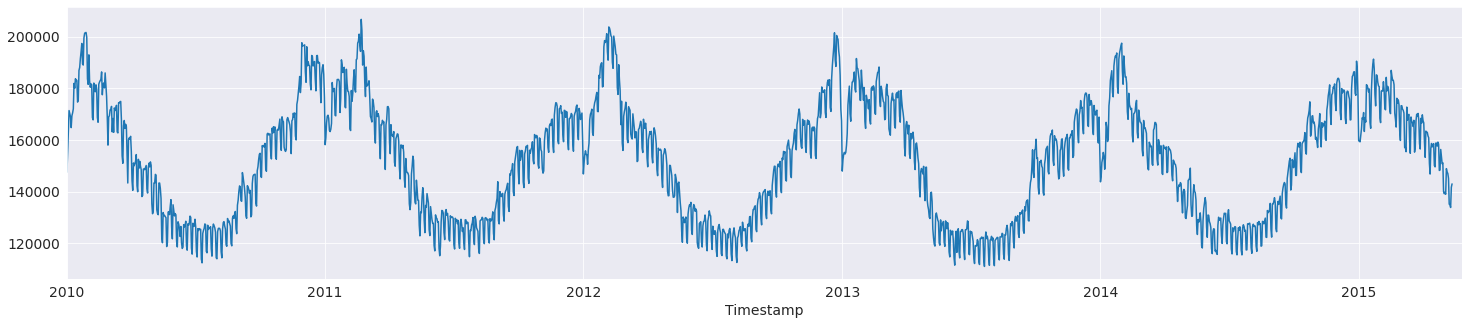

In [4]:
# See Year-Seasonality
energy_ts['EnergyConsump'].plot()

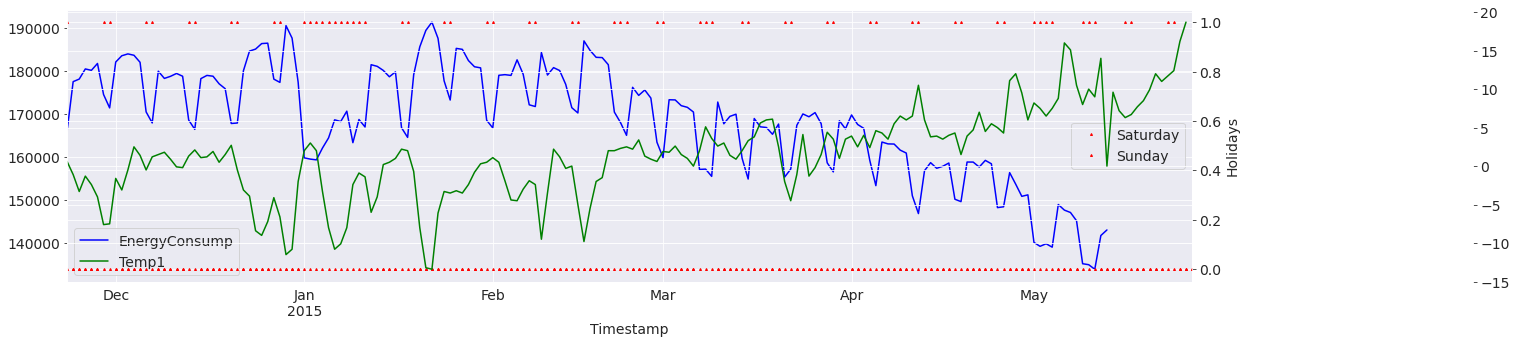

In [5]:
# See dependence on other varibales
fig, ax = plt.subplots()
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

In [9]:
# Stationary test
kpss_stat= stattools.kpss(energy_ts['EnergyConsump'].dropna())
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.093446, 
pvalue: 0.10 
maximal Lag: 27 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


## Analysis of original data

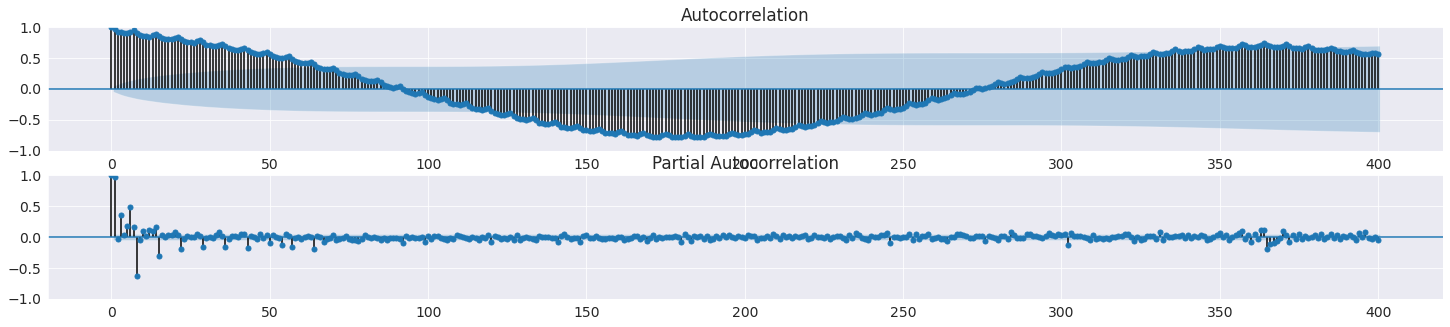

In [10]:
# ACF and PACF
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(energy_ts['EnergyConsump'].dropna(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(energy_ts['EnergyConsump'].dropna(), lags=400, ax=ax2)

**Question**
 - Can we use thiss ACF, PACF for choosing $p$,$q$?

In [18]:
energy_ts.columns[2:]

Index(['EnergyConsump', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'Temp5', 'Temp6',
       'Temp7', 'Saturday', 'Sunday', 'Temp1_South_Less', 'Temp2_South_Less',
       'Temp3_South_Less', 'Temp4_South_Less', 'Temp1_South_Gr',
       'Temp2_South_Gr', 'Temp3_South_Gr', 'Temp4_South_Gr'],
      dtype='object')

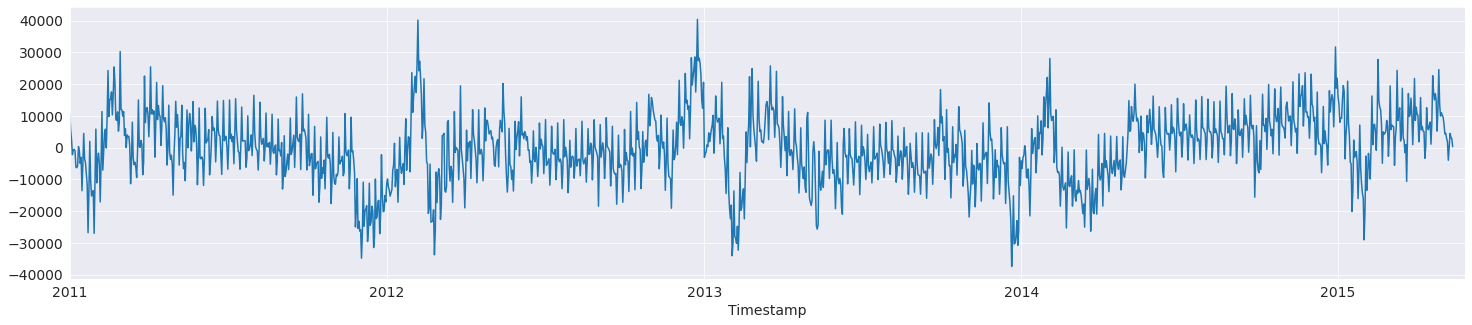

In [11]:
# Differencing
s = 365
dif365_energy = (energy_ts[energy_ts.columns[2:]] - energy_ts[energy_ts.columns[2:]].shift(s))[s:]
dif365_energy['EnergyConsump'].plot()

**Question:**
 * Is this TS stationary?

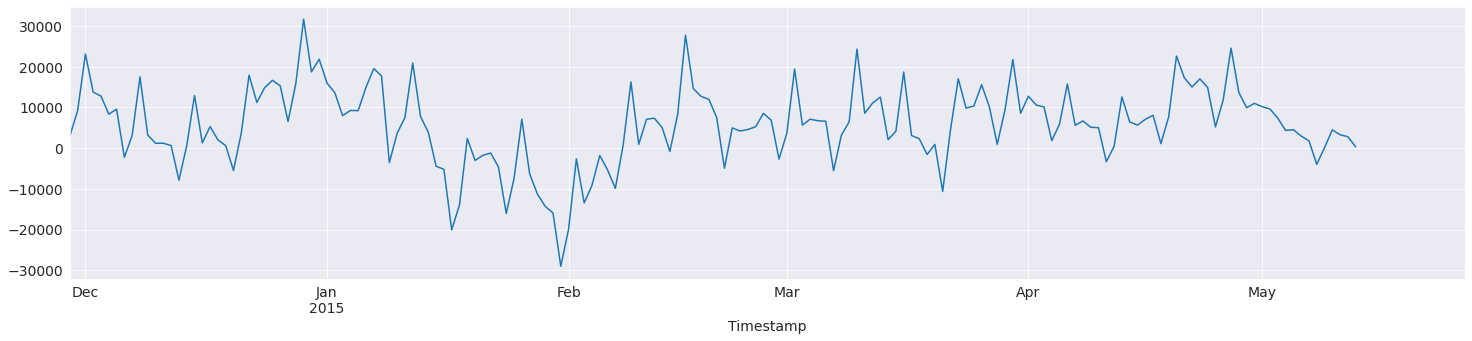

In [12]:
# Look closer
dif365_energy['EnergyConsump'].tail(180).plot()

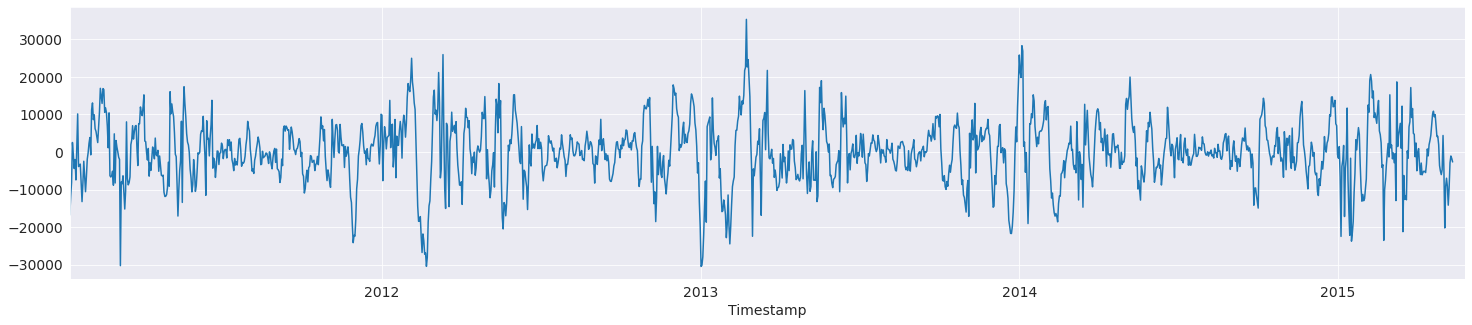

In [13]:

s=7
dif7_dif365_energy = (dif365_energy - dif365_energy.shift(s))[s:]
dif7_dif365_energy['EnergyConsump'].plot()

**Question:**
 * Is this TS stationary?

In [15]:
# Stationarity test
kpss_stat= stattools.kpss(np.array(dif7_dif365_energy['EnergyConsump'].dropna()))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.009227, 
pvalue: 0.10 
maximal Lag: 21 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* It seems that TS is stationary


**Question:** 
  * Are TS for exogenious variables stationary?

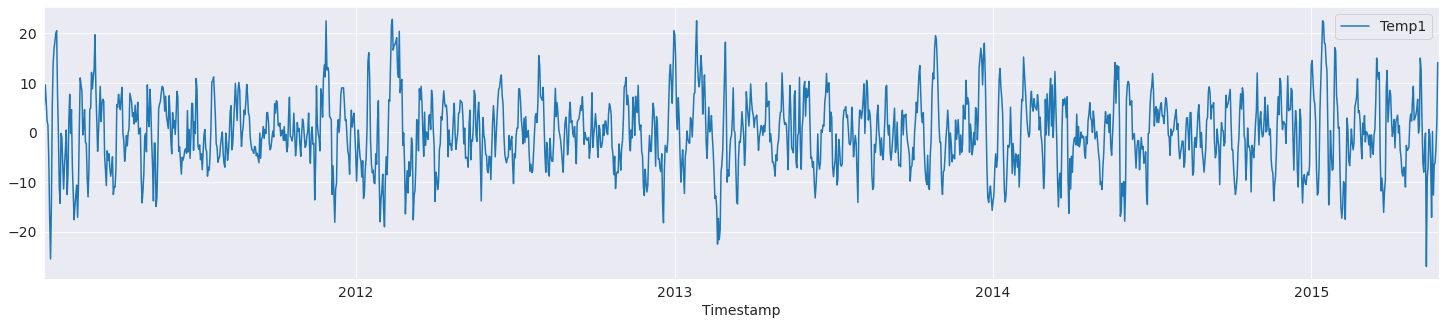

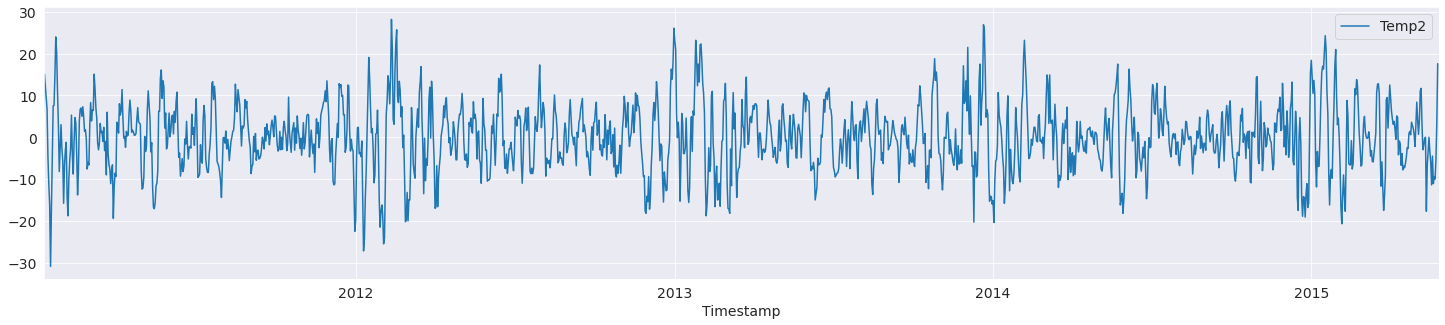

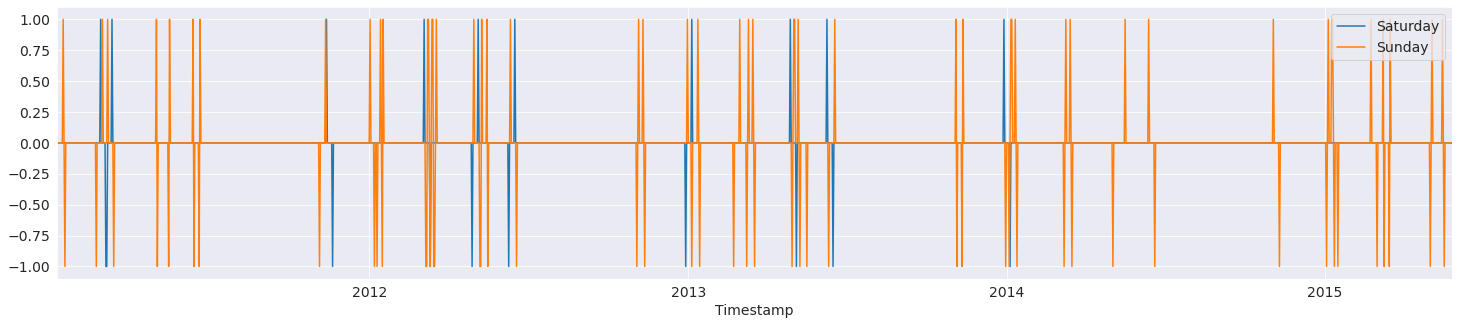

In [16]:
# plot grap for the individual variables
dif7_dif365_energy[['Temp1']].plot()
dif7_dif365_energy[['Temp2']].plot()
dif7_dif365_energy[['Saturday', 'Sunday']].plot()

In [18]:
# TODO: build KPSS test for all exog variables
kpss_stat= stattools.kpss(np.array(dif7_dif365_energy['Temp1'].dropna()))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.010020, 
pvalue: 0.10 
maximal Lag: 18 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


**Questions**:
  * What is $d$ and $D$ values for ARIMA?

## ARIMA for the stationary TS

In [19]:
# apply regression for the TS after differencing
exogs = dif7_dif365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']][dif7_dif365_energy.index<'2015-05-01']
extra_exogs = dif7_dif365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']]
ts = dif7_dif365_energy[['EnergyConsump']][dif7_dif365_energy.index<'2015-05-01']

In [21]:
# Only regressors
arima_mod000 = sm.tsa.ARIMA(endog = ts, order = (0,0,0), exog=exogs).fit()
print(arima_mod000.params)
print(arima_mod000.aic, arima_mod000.bic, arima_mod000.hqic)

const       3.611492e+01
Temp1      -4.557547e+02
Temp2      -9.474783e+01
Saturday   -8.821376e+03
Sunday     -1.039554e+04
sigma2      6.985191e+10
dtype: float64
42208.03700357163 42240.2052561455 42219.99196510225


### Defining $p, P, q, Q$

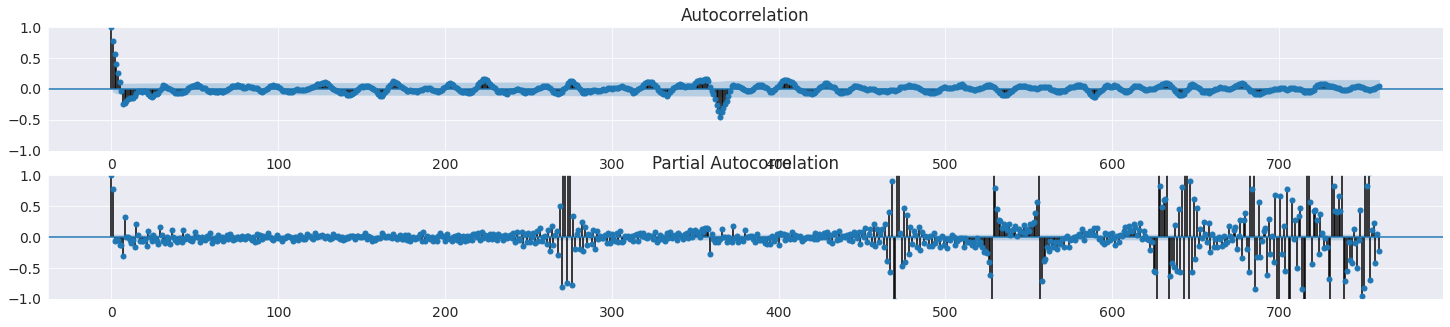

In [22]:
# acf for difference TS
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod000.resid.values.squeeze(), lags=760, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod000.resid.values.squeeze(), lags=760, ax=ax2)

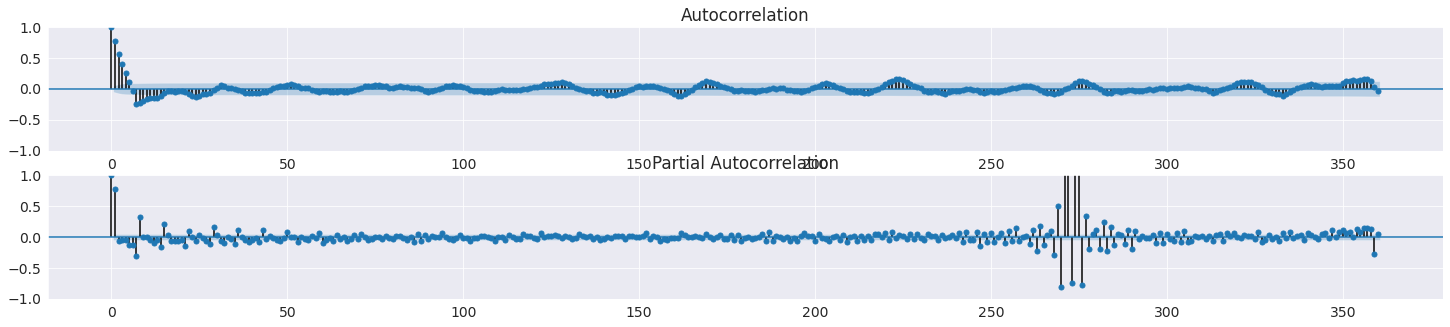

In [23]:
# acf for difference TS
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod000.resid.values.squeeze(), lags=360, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod000.resid.values.squeeze(), lags=360, ax=ax2)

**Questions**
   * What are candidates for $p$ and $q$?
      - $p$ ={}
      - $P$ = {}
      - $q$ = {}
      - $Q$ = {}

* Regression is rebuilt in supposition that the errors are described by model ARMA(p1,q1)

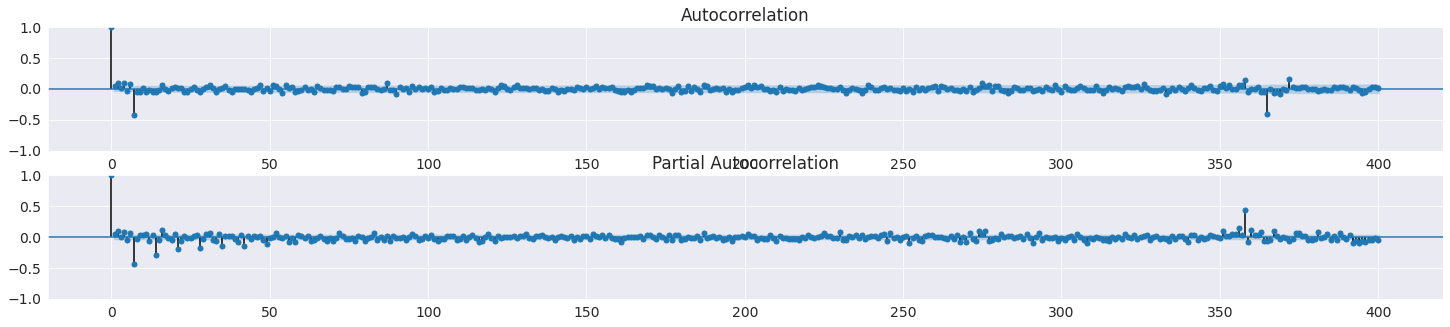

In [26]:
arima_mod100 = sm.tsa.ARIMA(endog = ts, order = (1,0,0), exog=exogs).fit()
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod100.resid.values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod100.resid.values.squeeze(), lags=400, ax=ax2)

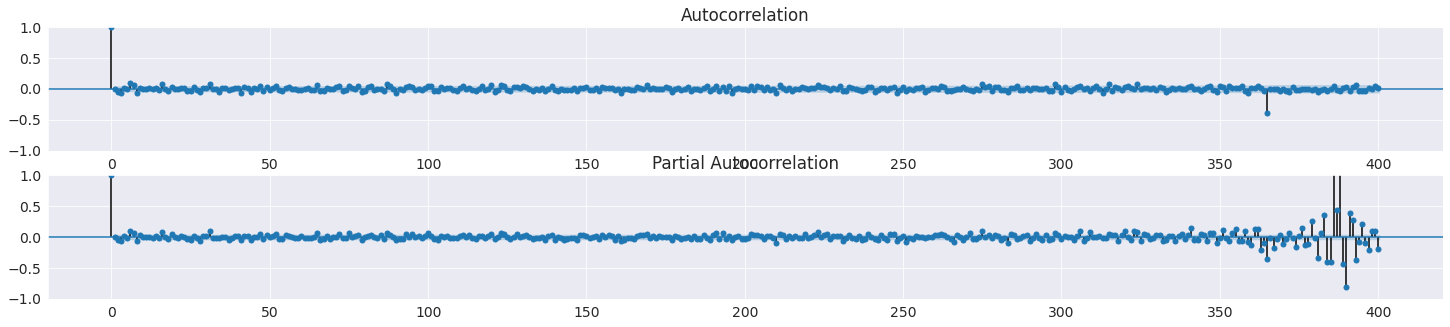

In [36]:
arima_mod107 = sm.tsa.ARIMA(endog = ts, order = (1,0,7), exog=exogs).fit()
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod107.resid.values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod107.resid.values.squeeze(), lags=400, ax=ax2)

**Questions**:
* How to compare this two models?
* What else should be considered?


In [29]:
print(arima_mod107.summary())

                               SARIMAX Results                                
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                 ARIMA(1, 0, 7)   Log Likelihood              -14974.445
Date:                Fri, 08 Oct 2021   AIC                          29976.891
Time:                        14:04:30   BIC                          30051.950
Sample:                    01-08-2011   HQIC                         30004.786
                         - 04-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.1139     57.814      0.625      0.532     -77.200     149.428
Temp1       -455.7008     29.640    -15.375      0.000    -513.793    -397.608
Temp2        -94.7086     29.328     -3.229      0.0

In [30]:
print(arima_mod100.summary())

                               SARIMAX Results                                
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -15233.424
Date:                Fri, 08 Oct 2021   AIC                          30480.848
Time:                        14:04:32   BIC                          30518.377
Sample:                    01-08-2011   HQIC                         30494.795
                         - 04-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.0439    627.516      0.056      0.955   -1194.865    1264.953
Temp1        -77.4525     23.791     -3.255      0.001    -124.083     -30.822
Temp2        -77.4932     20.765     -3.732      0.0

In [34]:
# Use Seasonal ARIMA
# arima_mod107_001 = sm.tsa.ARIMA(endog = ts, order = (1,0,7), seasonal_order = (0,0,1,365), exog=exogs).fit()
arima_mod107_001  = sm.tsa.statespace.SARIMAX(ts, order=(1,0,7), seasonal_order=(0,0,1,365)).fit()
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod107_001.resid.values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod107_001.resid.values.squeeze(), lags=400, ax=ax2)

KeyboardInterrupt: ignored

### Residuals analysis.

In [38]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_mod107.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.390194, 
pvalue: 0.08 
maximal Lag: 10 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* Residuals are stationary

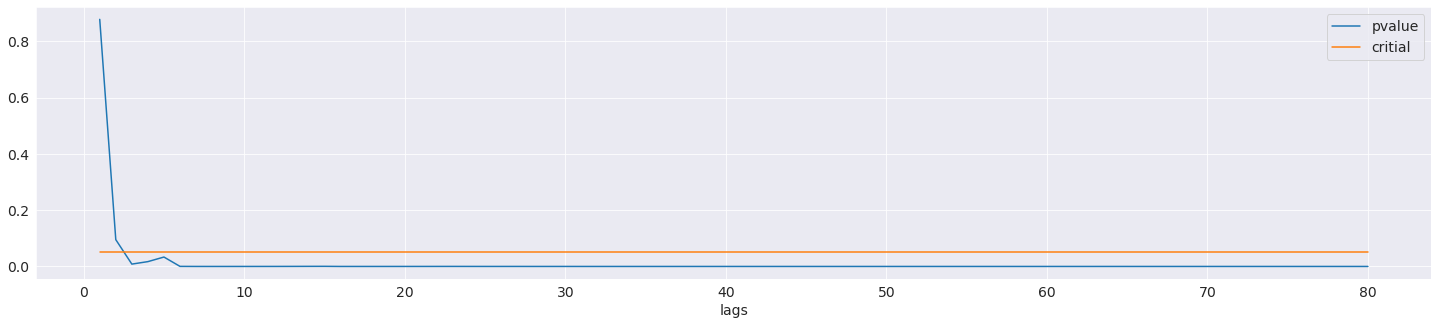

In [53]:
# Autocorrelation Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_mod107.resid.values, lags=80)['lb_pvalue'].values, 
              'critial':np.array([0.05]*80)}).set_index('lags').plot()
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

For lags 1-6 residuals are not correlated, but for lags 7 and grater seems residuals are correlated

In [54]:
# Unbiasedness Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod107.resid.values)

1.9799021995588195

Residuals are not biased!

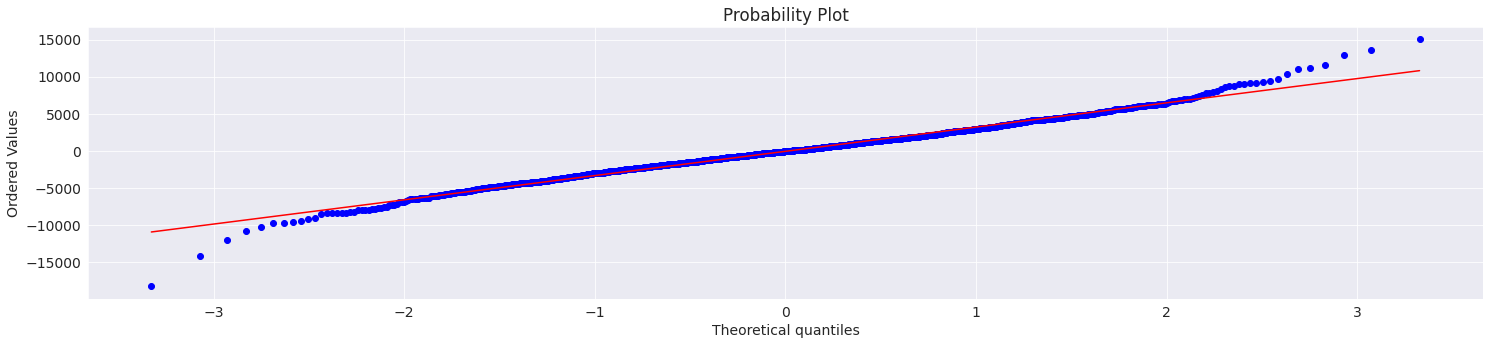

In [59]:
# Normaliry test
stats.normaltest(arima_mod107.resid)

# q-qPlot
fig = plt.figure()
res = stats.probplot(exogs_var.resid, dist="norm", plot = pylab)

* Hypothesis of normality can be rejected

### Analysis of the coefficients

In [140]:
print(arima_mod107.summary())

                               SARIMAX Results                                
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                 ARIMA(1, 0, 7)   Log Likelihood              -14974.445
Date:                Fri, 08 Oct 2021   AIC                          29976.891
Time:                        15:45:44   BIC                          30051.950
Sample:                    01-08-2011   HQIC                         30004.786
                         - 04-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.1139     57.814      0.625      0.532     -77.200     149.428
Temp1       -455.7008     29.640    -15.375      0.000    -513.793    -397.608
Temp2        -94.7086     29.328     -3.229      0.0

### Forecast for TS

In [72]:
# fig, ax = plt.subplots()
# fig = arima_mod107.plot_predict(start='2014-01-01', end='2015-04-30', ax=ax)
# arima_mod107.plot_diagnostics()
arima_mod107.predict()
arima_mod107.forecast
# legend = ax.legend(loc='upper left')

ValueError: ignored

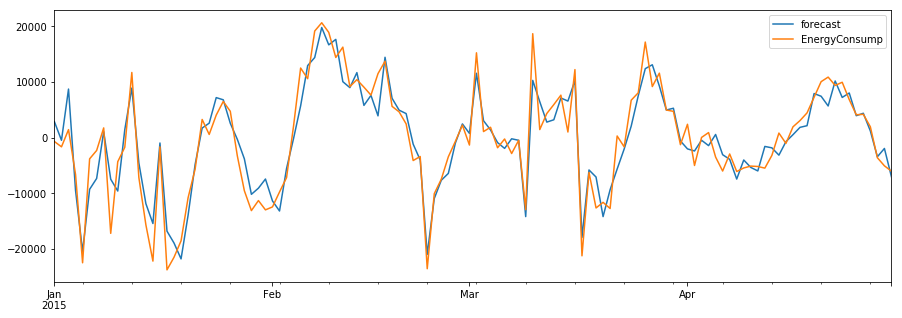

In [ ]:
fig, ax = plt.subplots()
fig = arima_mod107.plot_predict(start='2015-01-01', end='2015-04-30', ax=ax)

In [ ]:
# fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
# fig = arima_mod710_ex.plot_forecast(185)
frc = arima_mod107.forecast(steps = 13, exog = extra_exogs[extra_exogs.index>='2015-05-01'])

In [ ]:
frc_arimax = extra_exogs[extra_exogs.index>='2015-05-01']
frc_arimax['FRC'] = frc[0]
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



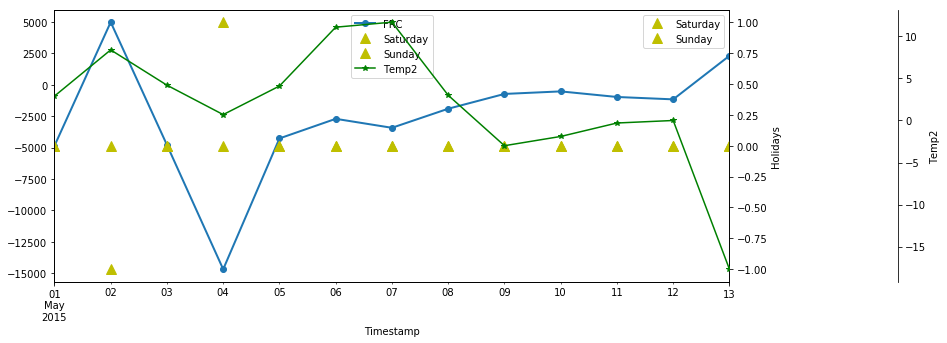

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

In [ ]:
# Practice: build the forecast of original TS


In [ ]:
# Practice: calculate MAPE for dates > 2015-05-01


**Question:** 
 * What is the period of seasonality for this TS? Another way to say: what are specifications of ARIMA model for this TS:
    - ARIMA (p,d,q)x(P,D,Q)_365
    - ARIMA (p,d,q)x(P,D,Q)_7

We will apply s=7 original ts
    - use additional exogenious variable that correspond seasonality s=365

## ARIMA for the original TS

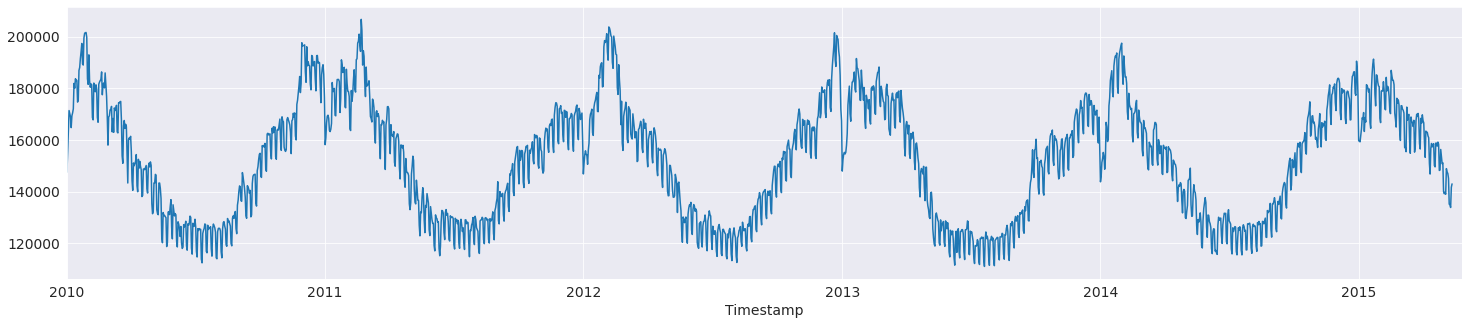

In [76]:
energy_ts['EnergyConsump'].plot()

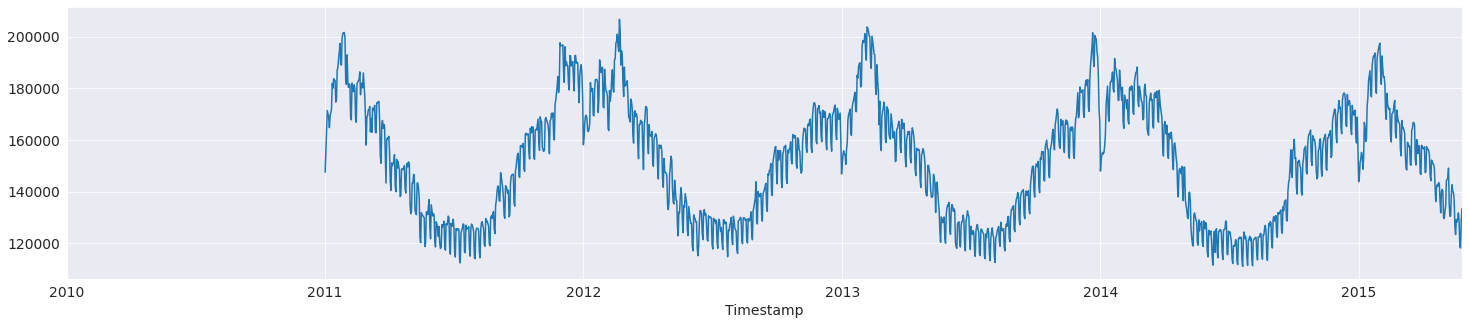

In [96]:
# prepare additional features

ext_energy_ts = energy_ts.merge(energy_ts.shift(365).rename(columns={'EnergyConsump':'EnergyConsump365'})['EnergyConsump365'], how = 'left', left_index = True, right_index = True)
ext_energy_ts['EnergyConsump365'].plot()

In [101]:
ext_energy_ts = ext_energy_ts[ext_energy_ts.index>'2011-01-01']
exogs = ext_energy_ts[['Temp1', 'Temp2', 'Saturday','Sunday', 'EnergyConsump365']][ext_energy_ts.index<'2015-05-01']

extra_exogs = ext_energy_ts[['Temp1', 'Temp2', 'Saturday','Sunday','EnergyConsump365']]
ts = ext_energy_ts[['EnergyConsump']][ext_energy_ts.index<'2015-05-01']

In [138]:
def fit_arima_7(ts, p,d,q,P,D,Q, exogs_var): 
    try:
        mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,7), exog = exogs_var)
        results = mod.fit()
        return("sarimax_%i%i%i_%i%i%i: aic=%f, bic=%f, hqic=%f " % (p,d,q,P,D,Q, 
               results.aic, results.bic, results.hqic))
    except Exception:
        return ("sarimax_%i%i%i_%i%i%i: can't fit model " % (p,d,q,P,D,Q))    

In [139]:
from sklearn.model_selection import ParameterGrid

param_grid = {'p': [1], 'd' : [0],
             'q': [0], 'P' : [1,2],
             'D': [1], 'Q' : [1,2]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(fit_arima_7(ts,params['p'], params['d'], params['q'], params['P'], params['D'], params['Q'], exogs_var = extra_exogs))

sarimax_100_111: can't fit model 
sarimax_100_112: can't fit model 
sarimax_100_211: can't fit model 
sarimax_100_212: can't fit model 


### Residuals analysis

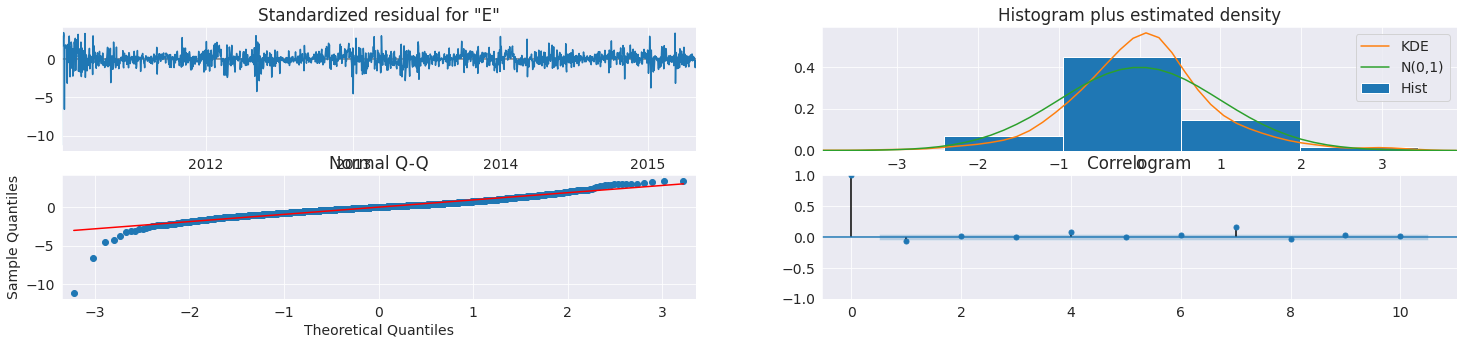

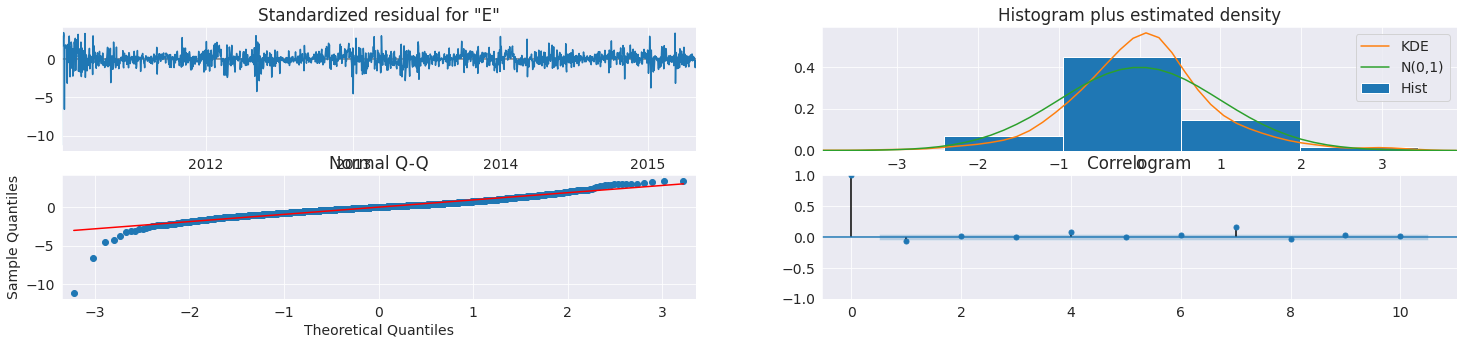

In [115]:
sarimax_100_111 = sm.tsa.statespace.SARIMAX(endog= ts, trend='n', 
                                            order=(1,0,0), seasonal_order=(1,1,1,7), exog=exogs).fit()
sarimax_100_111.plot_diagnostics()

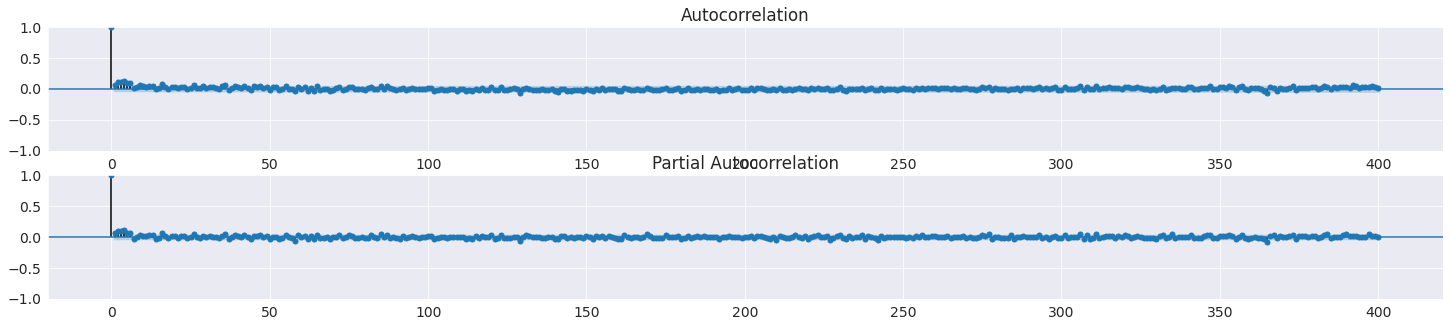

In [109]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_100_111.resid.values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_100_111.resid.values.squeeze(), lags=400, ax=ax2)

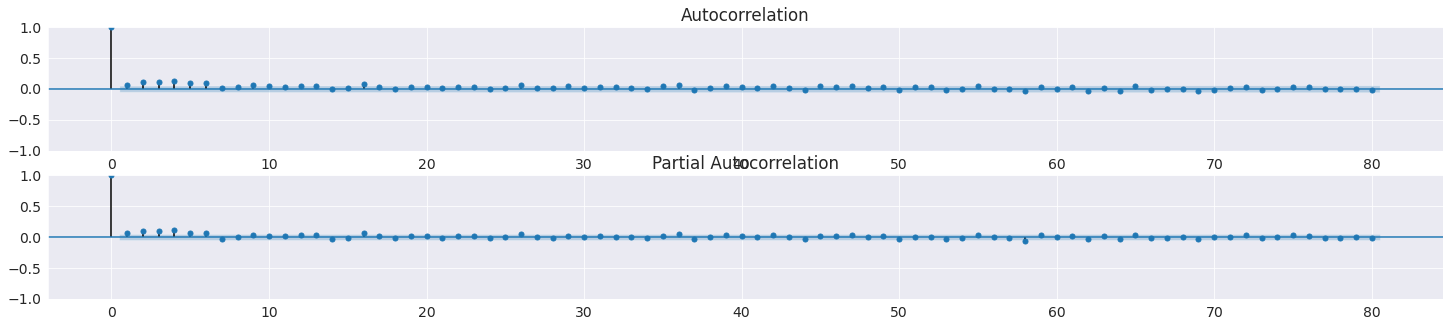

In [110]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_100_111.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_100_111.resid.values.squeeze(), lags=80, ax=ax2)

In [111]:
# Stationarity: Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(sarimax_100_111.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.417403, 
pvalue: 0.07 
maximal Lag: 17 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* Residuals are stationary

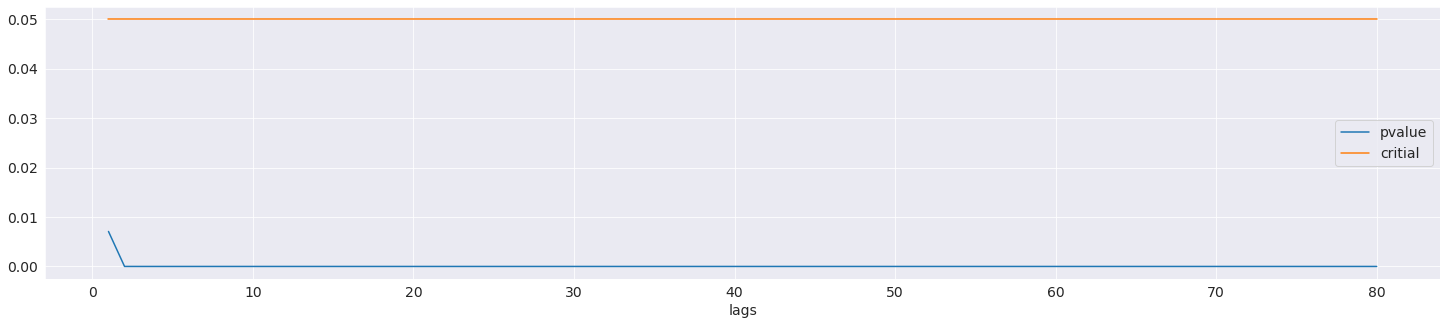

In [113]:
# Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(sarimax_100_111.resid.values, lags=80)['lb_pvalue'], 
              'critial':np.array([0.05]*80)}).set_index('lags').plot()

For lags 1-6 residuals are not correlated

In [114]:
# Unbiasedness test: Darbin_Watson statistic
sm.stats.durbin_watson(sarimax_100_111.resid.values)

1.5881387149009065

Residuals are not biased!

In [116]:
# Normality test
stats.normaltest(sarimax_100_111.resid)

NormaltestResult(statistic=1841.1791506999891, pvalue=0.0)

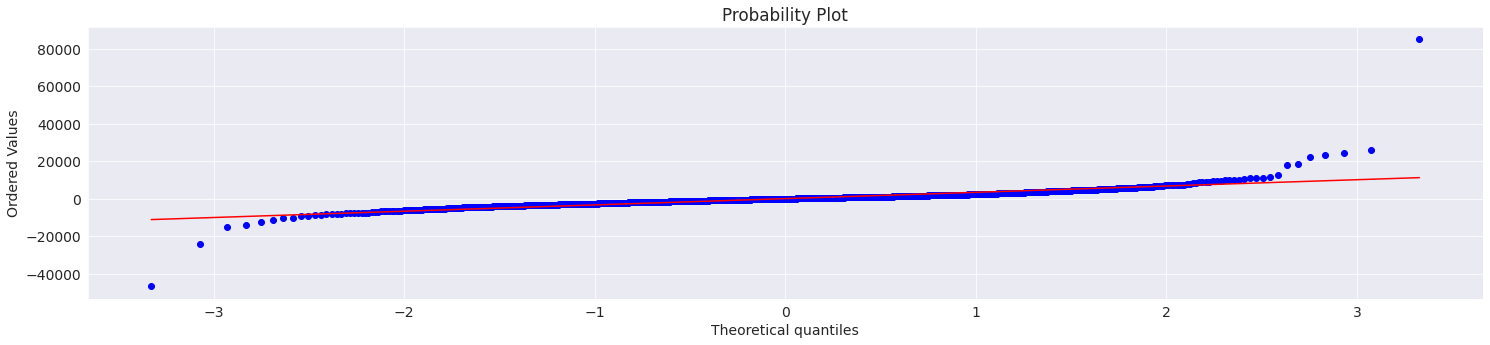

In [117]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(sarimax_100_111.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

### Analysis of the coefficients

In [142]:
print(sarimax_100_111.summary())

                                      SARIMAX Results                                      
Dep. Variable:                       EnergyConsump   No. Observations:                 1580
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood              -14884.234
Date:                             Fri, 08 Oct 2021   AIC                          29786.467
Time:                                     15:48:22   BIC                          29834.714
Sample:                                 01-02-2011   HQIC                         29804.398
                                      - 04-30-2015                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Temp1             -267.6448     41.838     -6.397      0.000    -349.647    -185.643
Temp2    

**Conclusion:** 
Temp 2 variable should be exlcuded from Exog variables.

### Forecast for future
The predict command is first applied here to get in-sample predictions. We use the full_results=True argument to allow us to calculate confidence intervals (the default output of predict is just the predicted values).
With no other arguments, predict returns the one-step-ahead in-sample predictions for the entire sample.

In [118]:
predict = sarimax_100_111.get_prediction()
predict_ci = predict.conf_int() # confidence interval

One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

In [119]:
#  Dynamic predictions
predict_dy = sarimax_100_111.get_prediction(dynamic='2014-01-01')
predict_dy_ci = predict_dy.conf_int() # confidence interval

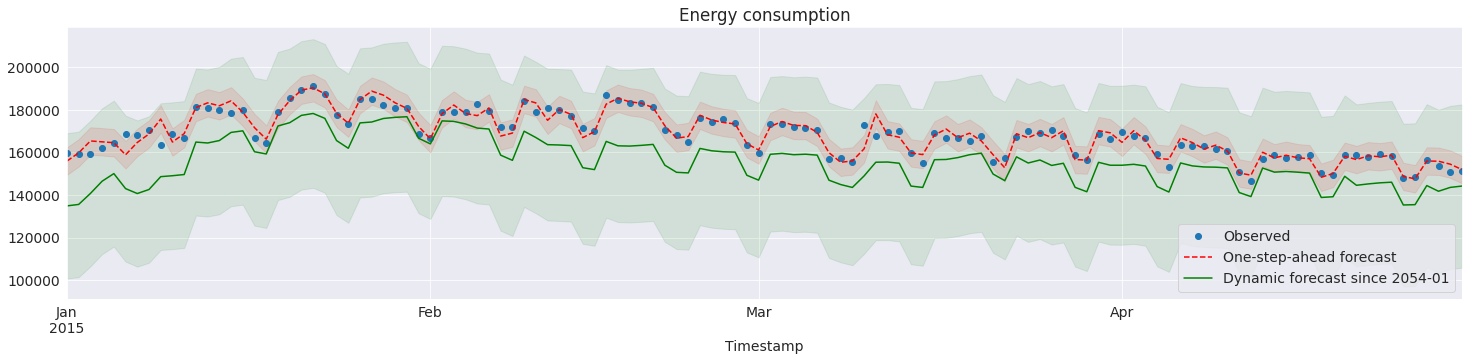

In [121]:
# Graph
fig, ax = plt.subplots()
npre = 4
ax.set(title='Energy consumption', xlabel='Date')

# Plot data points
ts.loc['2015-01-01':, 'EnergyConsump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean['2015-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2015-01-01':]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2015-01-01':].plot(ax=ax, style='g', label='Dynamic forecast since 2054-01')
ci = predict_dy_ci.loc['2015-01-01':]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

In [126]:
# forecast of future values
frc =sarimax_100_111.forecast(steps = 27, exog = extra_exogs[extra_exogs.index>='2015-05-01'].ffill())

In [131]:
frc_arimax = extra_exogs.loc['2015-05-01':]
frc_arimax['FRC'] = frc
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

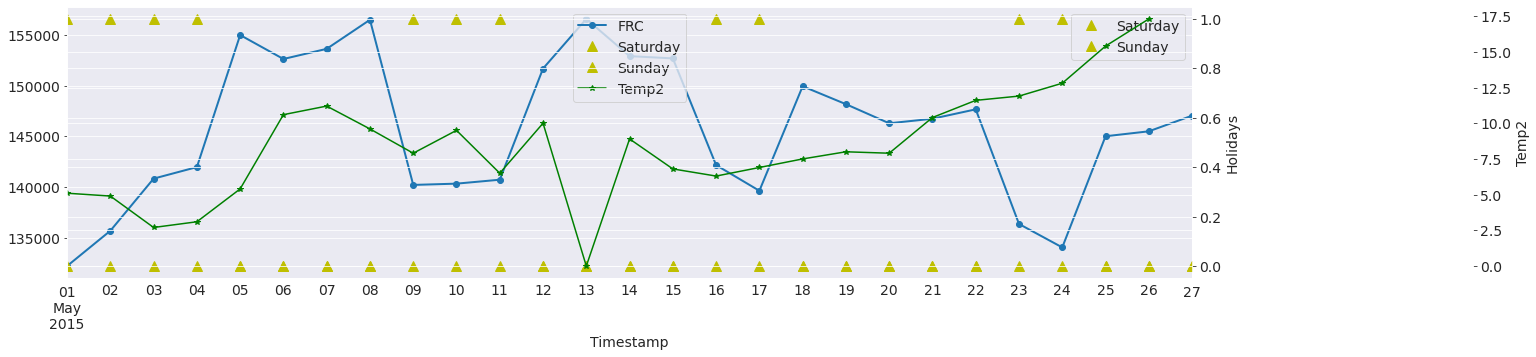

In [132]:
fig, ax = plt.subplots()

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

In [ ]:
# Practice: build the forecast of original TS


In [ ]:
# Practice: calculate MAPE for dates > 2015-05-01


In [ ]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts.head()
# Filter only Hub=Center and ZSP=FZSZOE27
energy_ts= energy_ts[(energy_ts['ZSP']=='FZSZOE27') & (energy_ts['Hub']=='Center')]
energy_ts.tail()

# See Year-Seasonality
energy_ts['EnergyConsump'].plot(figsize=(15,5))

# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_YearSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

# See Week easonality
energy_ts['EnergyConsump'].tail(186).plot(figsize=(15,5))

# re_energy = week_reshaping(energy_ts[['EnergyConsump']])
week_df = pd.DataFrame(index = energy_ts.index, columns = {'EnergyConsump', 'dayofweek', 'weekno'})
week_df['EnergyConsump'] = energy_ts['EnergyConsump']
week_df['dayofweek'] = week_df.index.dayofweek
week_df['weekno'] = week_df.index.week
week_df.head(10)

# See dependence on other varibales
fig, ax = plt.subplots(figsize=(15,5))
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

* **candidates values for q (according to ACF)** - 1, 9, 10 (don't look at 12 or greater: it's larger than period of seasonality)
* **candidates values for p (according to PACF)** - 1, 9 (don't look at 12 or greater: it's larger than period of seasonality)

In [ ]:
## Choosing best model accoridng to AIC criterion
arima_mod111 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,1)).fit()
print(arima_mod111.params)
print(arima_mod111.aic, arima_mod111.bic, arima_mod111.hqic)

const                 -0.000834
ar.L1.D.wage_boxcox   -0.539578
ma.L1.D.wage_boxcox    0.337118
dtype: float64
-991.4569907187226 -978.184510743 -986.088031868


In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arma_mod119 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,9)).fit()
print(arima_mod119.params)
print(arima_mod119.aic, arima_mod119.bic, arima_mod119.hqic)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arma_mod1110 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,10)).fit()
print(arima_mod1110.params)
print(arima_mod1110.aic, arima_mod1110.bic, arima_mod1110.hqic)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod911 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,1)).fit()
print(arima_mod911.params)
print(arima_mod911.aic, arima_mod911.bic, arima_mod911.hqic)

const                 -0.000846
ar.L1.D.wage_boxcox   -0.909261
ar.L2.D.wage_boxcox   -0.066992
ar.L3.D.wage_boxcox    0.047736
ar.L4.D.wage_boxcox    0.039425
ar.L5.D.wage_boxcox    0.058467
ar.L6.D.wage_boxcox    0.068016
ar.L7.D.wage_boxcox    0.006379
ar.L8.D.wage_boxcox   -0.082354
ar.L9.D.wage_boxcox    0.073923
ma.L1.D.wage_boxcox    0.761500
dtype: float64
-988.2653500338749 -948.447910108 -972.158473483


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod919 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,9)).fit()
print(arima_mod919.params)
print(arima_mod919.aic, arima_mod919.bic, arima_mod919.hqic)

const                 -0.000976
ar.L1.D.wage_boxcox   -0.150403
ar.L2.D.wage_boxcox    0.519736
ar.L3.D.wage_boxcox    0.275666
ar.L4.D.wage_boxcox    0.275282
ar.L5.D.wage_boxcox   -0.024404
ar.L6.D.wage_boxcox   -0.182132
ar.L7.D.wage_boxcox   -0.598245
ar.L8.D.wage_boxcox   -0.227851
ar.L9.D.wage_boxcox    0.698578
ma.L1.D.wage_boxcox   -0.049985
ma.L2.D.wage_boxcox   -0.570083
ma.L3.D.wage_boxcox   -0.284679
ma.L4.D.wage_boxcox   -0.279555
ma.L5.D.wage_boxcox    0.281655
ma.L6.D.wage_boxcox    0.261406
ma.L7.D.wage_boxcox    0.597745
ma.L8.D.wage_boxcox   -0.007092
ma.L9.D.wage_boxcox   -0.943805
dtype: float64
-1004.279374514849 -937.916974638 -977.434580264


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod9110 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,10)).fit()
print(arima_mod9110.params)
print(arima_mod9110.aic, arima_mod9110.bic, arima_mod9110.hqic)

const                  -0.000956
ar.L1.D.wage_boxcox    -0.332327
ar.L2.D.wage_boxcox     0.485708
ar.L3.D.wage_boxcox     0.249135
ar.L4.D.wage_boxcox     0.163675
ar.L5.D.wage_boxcox     0.128084
ar.L6.D.wage_boxcox    -0.110585
ar.L7.D.wage_boxcox    -0.600725
ar.L8.D.wage_boxcox    -0.135955
ar.L9.D.wage_boxcox     0.660917
ma.L1.D.wage_boxcox     0.111328
ma.L2.D.wage_boxcox    -0.665728
ma.L3.D.wage_boxcox    -0.238999
ma.L4.D.wage_boxcox    -0.057646
ma.L5.D.wage_boxcox     0.075386
ma.L6.D.wage_boxcox     0.261861
ma.L7.D.wage_boxcox     0.663913
ma.L8.D.wage_boxcox    -0.231085
ma.L9.D.wage_boxcox    -0.951199
ma.L10.D.wage_boxcox    0.034378
dtype: float64
-995.7245159431063 -926.043996072 -967.537481979


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



* According to AIC criterion arma_mod919 is best of this 6 models

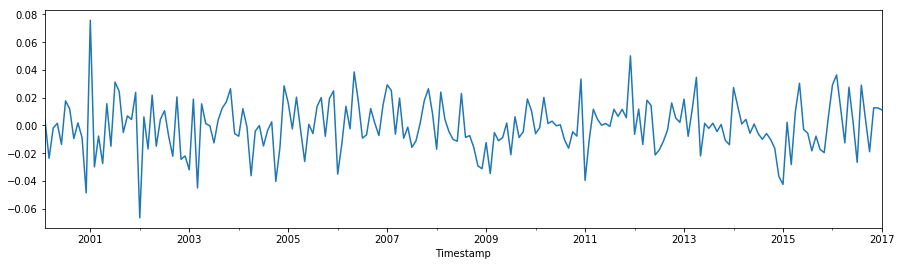

In [ ]:
# plot residuals
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = arima_mod919.resid.plot(ax=ax, figsize=(15,4));

Values of the TS are not correlated

In [ ]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod919.resid.values)

2.0933382031995951

In [ ]:
stat = stats.wilcoxon(arima_mod919.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 10183.000000
pvalue: 0.75


Residuals are not biased!

# Conclusion
## Approach how to fit ARIMA

<img src = 'https://www.autobox.com/cms/images/easyblog_images/64/arimaredo.png'>


<!-- 
## Self-check questions
  1. -->


## HW2 preview    

**Materials**
* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

* Autocorrelation analysis

  - https://online.stat.psu.edu/stat510/lesson/2

  - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model